In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [18]:
train_log = pd.read_csv("train_log4.csv")
val_log = pd.read_csv("val_log5.csv")

In [19]:
train_log.head()

,Epoch,Loss,Accuracy,Timestamp
0,1,0.694240,55.46875,2024-11-17 08:23:59
1,2,0.670403,56.25000,2024-11-17 09:17:47
2,3,0.668144,64.84375,2024-11-17 10:11:36
3,4,0.660233,64.06250,2024-11-17 11:05:20
4,5,0.660898,61.71875,2024-11-17 11:58:42


In [20]:
val_log.head()

,Epoch,Loss,Accuracy,Timestamp
0,1,0.708216,44.117647,2024-11-17 08:23:59
1,2,0.685083,53.921569,2024-11-17 09:17:47
2,3,0.682749,59.803922,2024-11-17 10:11:36
3,4,0.702748,56.862745,2024-11-17 11:05:20
4,5,0.696495,51.960784,2024-11-17 11:58:42


In [21]:
train_epochs = train_log['Epoch']
train_loss = train_log['Loss']
val_epochs = val_log['Epoch']
val_loss = val_log['Loss']

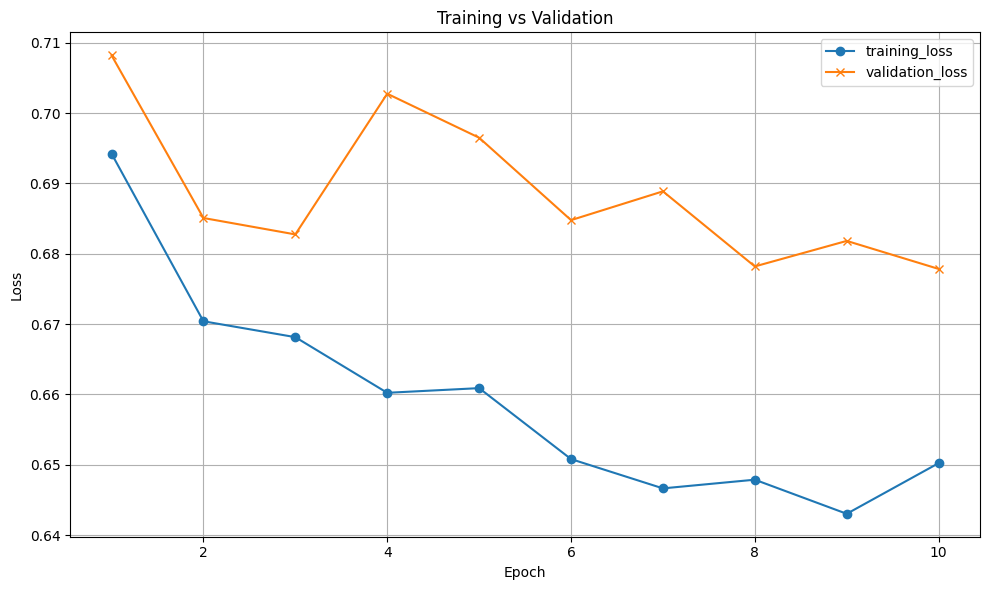

In [22]:
plt.figure(figsize=(10,6))
plt.plot(train_epochs, train_loss, label="training_loss", marker='o')
plt.plot(val_epochs, val_loss, label="validation_loss", marker='x')

plt.title("Training vs Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
train_acc = train_log['Accuracy']
val_acc = val_log['Accuracy']

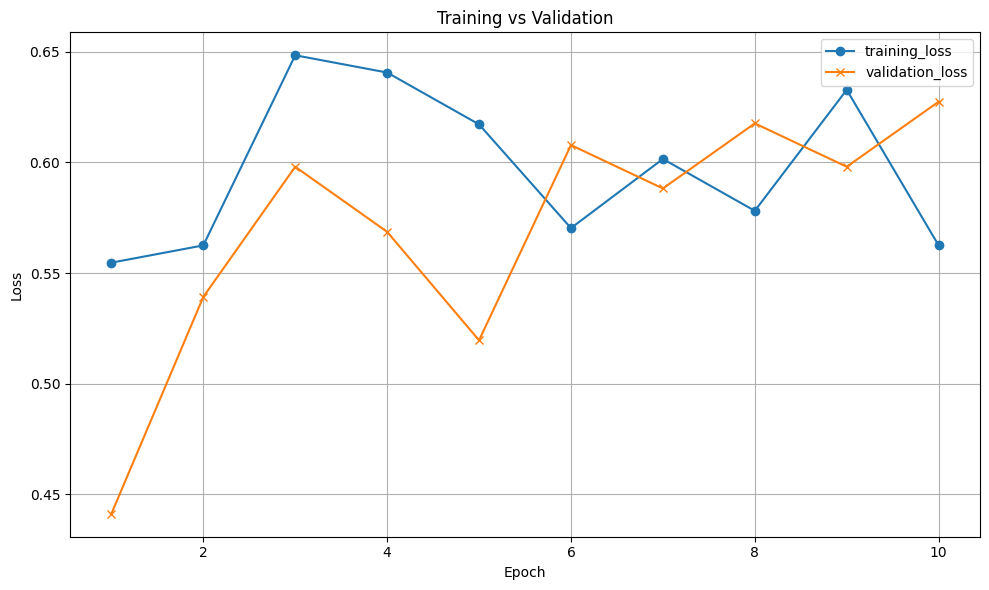

In [24]:
plt.figure(figsize=(10,6))
plt.plot(train_epochs, train_acc/100, label="training_loss", marker='o')
plt.plot(val_epochs, val_acc/100, label="validation_loss", marker='x')

plt.title("Training vs Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.models import vgg16_bn
from torchvision.models import VGG16_BN_Weights
from PIL import Image
import cv2
import pydicom
import numpy as np

Predicted Probability of Positive Class: 0.4644


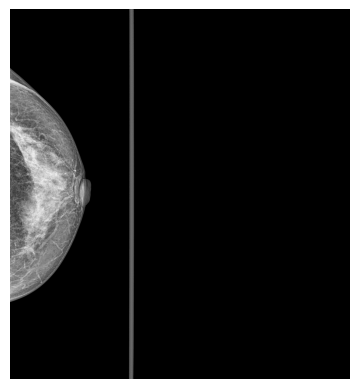

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model architecture
vgg16_bn_weights = VGG16_BN_Weights.DEFAULT
model = vgg16_bn(weights=vgg16_bn_weights)

# Modify the classifier to match the trained setup
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([torch.nn.Linear(num_features, 1)])
model.classifier = torch.nn.Sequential(*features)

model.load_state_dict(torch.load('MoCad2.pt', map_location=device, weights_only=True))
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def infer_image(image_path):
    """
    Perform inference on a single image.
    Args:
        image_path (str): Path to the input image.
    Returns:
        float: Predicted probability of the positive class.
    """
    # Load and preprocess the image
    ds = pydicom.dcmread(image_path)
    image = ds.pixel_array
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    photometric_interpretation = ds.get('PhotometricInterpretation', None)
    if photometric_interpretation == "MONOCHROME1":
        image = 255 - image  # Invert
    image = image.astype(np.float32) / 255.0
    image = np.stack([image] * 3, axis=0)
    plt_image = image
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()

    return prob, plt_image

# Example usage
image_path = '/home/whif/Data/RSNA/train_images/10006/462822612.dcm'
predicted_prob, image = infer_image(image_path)
print(f"Predicted Probability of Positive Class: {predicted_prob:.4f}")
if image.shape[0] == 3:
    image = np.transpose(image, (1, 2, 0))
plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
plt.axis('off')
plt.show()

In [27]:
RSNA_path = '/home/whif/Data/RSNA/train_images'
RSNA_csv = pd.read_csv("~/Data/balanced_dataset.csv")
Balanced_RSNA_DDSM = pd.read_csv("~/Data/DDSM2/balanced_dataset.csv")
RSNA_DDSM_Path = '/home/whif/Data/DDSM2/full_images'

In [28]:
transform = transforms.Compose(
    [
     transforms.Resize((256,256)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(0.5)])

In [29]:
class Dataset_Visual(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_data = img_data
        self.img_path = img_path
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        # Get the image path
        img_name = os.path.join(self.img_path, str(self.img_data.loc[index, 'patient_id']), str(self.img_data.loc[index, 'image_id']) + '.dcm')
        
      
        ds = pydicom.dcmread(img_name, force=True)
        image = ds.pixel_array  
        
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)
        
        photometric_interpretation = ds.get('PhotometricInterpretation', None)

        if photometric_interpretation == "MONOCHROME1":

        # Invert the image
            image = 255 - image

    
        image = image.astype(np.float32) / 255.0

 
        image = np.stack([image] * 3, axis=0)   
        image = torch.tensor(image, dtype=torch.float32)  

       
        if self.transform:
            image = self.transform(image)

   
        label = torch.tensor(self.img_data.loc[index, 'cancer'], dtype=torch.long)  
        return image, label

In [34]:
dataset_visual = Dataset_Visual(RSNA_csv, RSNA_path, transform)
val, test = torch.utils.data.random_split(dataset = dataset_visual,
                                                         lengths = [20, 2338], generator = torch.Generator().manual_seed(42))
test_loader = torch.utils.data.DataLoader(val, batch_size = 128)

In [35]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
)

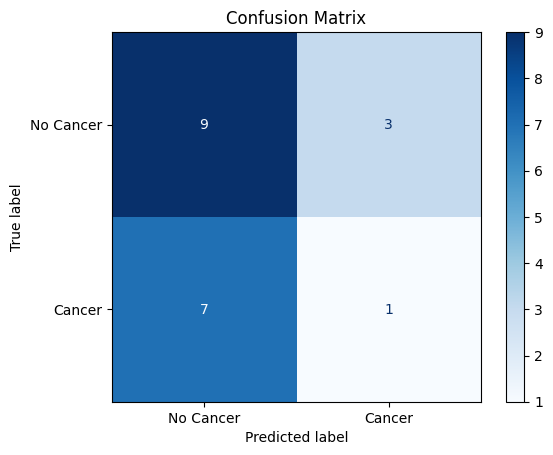

Precision: 0.25
Sensitivity (Recall): 0.12
F1-Score: 0.17


In [36]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on a dataset and generate predictions and ground truth labels.

    Parameters:
        model: Trained PyTorch model
        dataloader: PyTorch DataLoader for evaluation
        device: Device to run inference ('cpu' or 'cuda')

    Returns:
        y_true: Ground truth labels
        y_pred: Predicted labels
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            predicted_probs = torch.sigmoid(outputs).cpu().numpy()  # For binary classification
            predicted_labels = (predicted_probs > 0.5).astype(int).flatten()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_labels)

    return np.array(y_true), np.array(y_pred)


def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot a confusion matrix using sklearn.

    Parameters:
        y_true: Ground truth labels
        y_pred: Predicted labels
        class_names: List of class names (e.g., ['No Cancer', 'Cancer'])
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()


def calculate_metrics(y_true, y_pred):
    """
    Calculate precision, recall (sensitivity), and F1-score.

    Parameters:
        y_true: Ground truth labels
        y_pred: Predicted labels

    Returns:
        None
    """
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Sensitivity
    f1 = f1_score(y_true, y_pred)

    print(f"Precision: {precision:.2f}")
    print(f"Sensitivity (Recall): {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")


# Example usage
# Assuming you have your model, dataloader, and device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model and get predictions
y_true, y_pred = evaluate_model(model, test_loader, device)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names=["No Cancer", "Cancer"])

# Calculate precision, sensitivity, and F1-score
calculate_metrics(y_true, y_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843137..1.0000001].


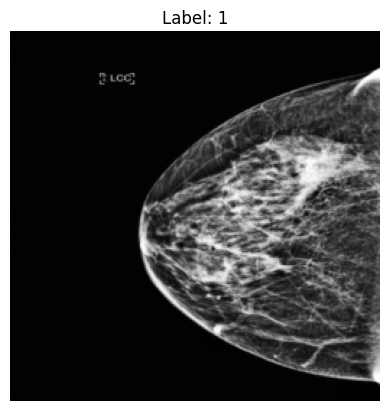

In [20]:
image, label = dataset_visual[1500]

denormalized_image = image * 0.5 + 0.5 

image_to_show = denormalized_image.permute(1, 2, 0)
plt.imshow(image_to_show.numpy())
plt.title(f"Label: {label.item()}")
plt.axis("off")  
plt.show()

In [18]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        # Forward pass
        output = self.model(input_image)
        self.model.zero_grad()

        predicted_prob = torch.sigmoid(output).item()
        
        target = output[0, target_class]
        target.backward()

        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * activations, dim=1).squeeze()
        cam = F.relu(cam)

        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.cpu().detach().numpy(), predicted_prob

In [73]:
target_layer = model.features[-1]
grad_cam = GradCAM(model, target_layer)

model.eval()
sample_image, label = dataset_visual[1700]
sample_image = sample_image.unsqueeze(0).to(device)

target_class = 0
cam, predicted_prob = grad_cam.generate_cam(sample_image, target_class)

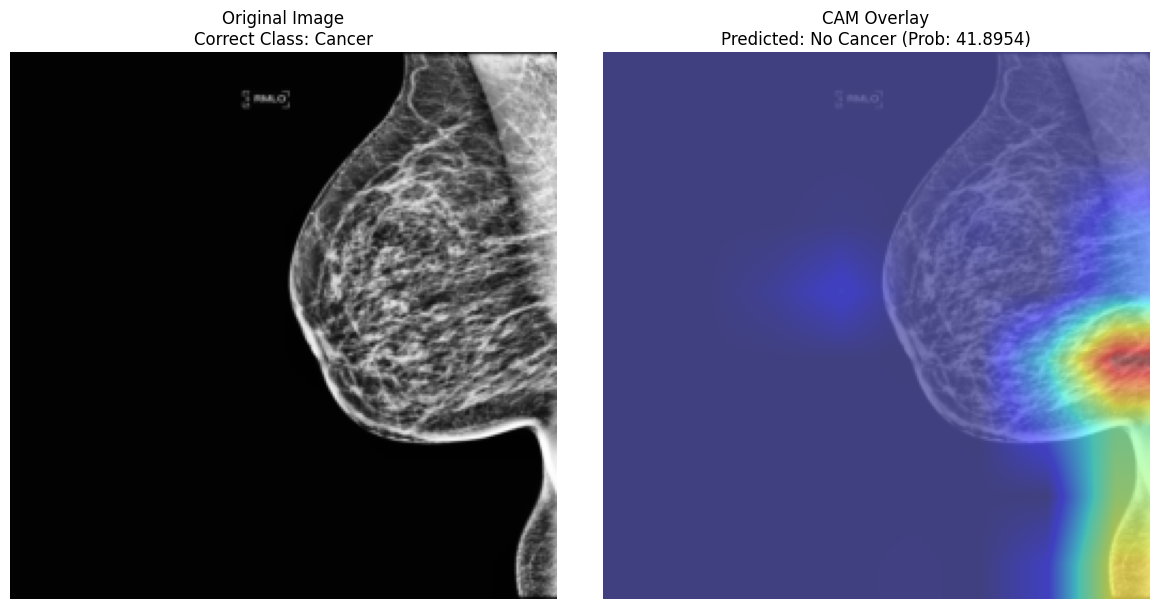

In [74]:
original_image = sample_image[0].cpu().permute(1, 2, 0).numpy()  # Convert tensor to image
cam_resized = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))

# Denormalize the original image 
denormalized_image = original_image * 0.5 + 0.5
denormalized_image = np.clip(denormalized_image, 0, 1)

# Define the class label
original_class = "Cancer" if label.item() == 1 else "No Cancer"
overlay_class = "Cancer" if predicted_prob > 0.5 else "No Cancer"

# Create a figure for side-by-side display
plt.figure(figsize=(12, 6))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(denormalized_image)
plt.axis('off')
plt.title(f"Original Image\nCorrect Class: {original_class}")

# Display the overlayed CAM
plt.subplot(1, 2, 2)
plt.imshow(denormalized_image, alpha=0.5)
plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"CAM Overlay\nPredicted: {overlay_class} (Prob: {100*predicted_prob:.4f})")

# Show the plots
plt.tight_layout()
plt.show()
